# GBRT con entradas + salidas

Ya se ha realizado anteriormente la predicción para valores utilizando solamente los conteos que corresponden a las entradas por estación. Para este experimento se tiene contemplado utilizar los conteos de las entradas + salidas de cada estación con la finalidad de que exista una diferencia mayor entre el rango de las estaciones al momento de ser ordenadas.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
from sklearn import preprocessing

%matplotlib inline

In [2]:
def load_daytrips():
    path = r'D:\ownCloud\Documentos posgrado\Posgrado 2do semestre\Seminario investigacion\Experimental Data\Cd Mex\Movilidad\Hist Ecobici\ecobici.csv'
    trips = pd.read_csv(path,
                    parse_dates=['date_removed', 'date_arrived'],
                    infer_datetime_format=True,
                    low_memory=False)
    
    trips = trips.loc[trips['action'] != 'C  ']

    # Find the start date
    ind = pd.DatetimeIndex(trips.date_arrived)
    trips['date'] = ind.date.astype('datetime64')
    trips['hour'] = ind.hour

    # Count trips by date
    by_date_out = trips.pivot_table('bike',aggfunc='count',
                            index='date',
                            columns='station_arrived', )
    by_date_in = trips.pivot_table('bike',aggfunc='count',
                            index='date',
                            columns='station_removed', )
    
    by_date = by_date_in.add(by_date_out, fill_value=0)

    # add a flag indicating weekend
    by_date['weekend'] = (by_date.index.dayofweek >= 5)
    
    by_date_weekday = by_date[by_date['weekend'] == False]

    mavg_wd = by_date_weekday.sum(axis=1).rolling(window=20,center=False).mean()
    mstd_wd = by_date_weekday.sum(axis=1).rolling(window=20,center=False).std()

    black_list = by_date_weekday.sum(axis=1)[by_date_weekday.sum(axis=1) <= mavg_wd-2*mstd_wd].index

    by_date_weekend = by_date[by_date['weekend'] == True]

    mavg_we = by_date_weekend.sum(axis=1).rolling(window=20,center=False).mean()
    mstd_we = by_date_weekend.sum(axis=1).rolling(window=20,center=False).std()

    black_list = black_list.union(by_date_weekend.sum(axis=1)[by_date_weekend.sum(axis=1) <= mavg_we-2*mstd_we].index)
    
    # remove those values on the blacklist
    by_date = by_date.fillna(0)
    by_date = by_date.loc[~by_date.index.isin(black_list)]
    
    return by_date

In [3]:
by_date = load_daytrips()

station_phase_path = r'C:\Users\ghost\Google Drive\JairCastruitaGastelum\Progress Reports\Clustering_ECOBICI\DATA\ecobiciFases.csv'
station_phase = pd.read_csv(station_phase_path,header=None)
station_phase.columns = ['station','phase']

by_date.drop([col for col in list(by_date.columns.values) if col not in station_phase[station_phase['phase'] <= 1]['station'].values or col >= 260], 
        axis=1, inplace=True)

# Keep only weekdays to make a more stable count signal
by_date = by_date[by_date.index.dayofweek < 5]

phase1 = by_date['2010-02-20':'2012-10-29'].copy()

C:\Users\ghost\AppData\Local\Enthought\Canopy\User\lib\site-packages\ipykernel\__main__.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


In [4]:
phase1.head()

,1,2,3,4,5,6,7,8,9,10,...,81,82,83,84,85,86,87,88,89,90
date,,,,,,,,,,,,,,,,,,,,,
2010-02-22,0.0,0.0,0.0,0.0,16.0,6.0,9.0,10.0,0.0,0.0,...,0.0,0.0,9.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0
2010-02-23,0.0,0.0,0.0,0.0,15.0,1.0,2.0,7.0,0.0,0.0,...,0.0,0.0,5.0,6.0,24.0,0.0,0.0,0.0,0.0,0.0
2010-02-24,0.0,3.0,0.0,7.0,6.0,2.0,5.0,3.0,2.0,2.0,...,0.0,0.0,3.0,1.0,19.0,0.0,0.0,0.0,0.0,0.0
2010-02-25,0.0,6.0,0.0,3.0,5.0,3.0,2.0,2.0,2.0,0.0,...,0.0,0.0,1.0,2.0,15.0,0.0,0.0,0.0,0.0,0.0
2010-02-26,0.0,11.0,0.0,9.0,3.0,17.0,2.0,5.0,5.0,38.0,...,0.0,1.0,4.0,6.0,84.0,0.0,0.0,0.0,0.0,0.0


Se extraen los elementos de head, body y tail, propios de rank diversity:

In [5]:
data = dict([(r[0], list(phase1.columns[np.argsort(list(r)[1: ])[::-1]])) \
        for r in list(phase1.to_records())])
    
dr = pd.DataFrame.from_dict(data, orient='index', dtype=None)
dr = dr.sort_index()

head = np.unique(dr[[0]])

tail = np.setdiff1d(dr[89].unique(), dr[0].unique())

body = np.setdiff1d(dr[50].unique(), head)
body = np.setdiff1d(body, tail)

In [6]:
print 'Head:',head,'\n'
print 'Body:',body,'\n'
print 'Tail:',tail,'\n'

Head: [ 1 13 17 18 20 27 29 31 36 46 49 64 70 84 85] 

Body: [ 4  5  6  7 11 16 19 21 23 28 35 37 38 40 42 45 47 50 51 53 56 57 58 60 61
 63 66 68 69 72 73 74 75 76 79 81] 

Tail: [ 2  3  8  9 10 12 14 15 22 24 25 26 30 32 33 34 39 41 43 44 48 52 54 55 59
 62 65 67 71 77 78 80 82 86 87 88 89 90] 



Tras haber obtenido los subconjuntos de rank diversity puede observarse que no hay un cambio radical entre las estaciones que ocupan las posiciones seleccionadas, por lo que podemos pensar que rank diversity para este caso no se vio afectado.

In [7]:
phase1.columns.name = 'station'

In [8]:
phase_aux = phase1.transpose()
phase_transformed = pd.melt(phase_aux.reset_index(), id_vars=["station"], 
                  var_name="Date", value_name="Value").sort_values(["station",'Date'])
phase_transformed = phase_transformed.set_index('Date')

In [9]:
phase_transformed['weekday'] = phase_transformed.index.dayofweek

In [10]:
phase_transformed['rolling'] = phase_transformed.groupby('station')['Value'].apply(lambda x: x.rolling(window=10,center=False).mean())

In [11]:
phase_transformed['shift'] = phase_transformed.groupby('station')['Value'].shift(periods=1)

In [12]:
phase_transformed = phase_transformed.dropna()

In [13]:
def makeData(data):
    tdata = data.transpose()
    tdata_row = pd.melt(tdata.reset_index(), id_vars=["station"], 
                      var_name="Date", value_name="Rank")

    tdata_row = tdata_row.sort_values(["station",'Rank'])
    tdata_row = tdata_row.set_index('Date')

    return tdata_row

In [14]:
train = phase_transformed[:'2012-09-29']
test = phase_transformed['2012-09-29':]

In [15]:
rank1 = phase1.rank(axis='columns', ascending=False, method='first')

In [16]:
train_rank = rank1['2010-09-01':'2012-08-29']
test_rank = rank1['2012-08-29':]

In [17]:
train_rank_whole, test_rank_whole = makeData(train_rank), makeData(test_rank)

train = train.reset_index()
train_rank_whole = train_rank_whole.reset_index()

test = test.reset_index()
test_rank_whole = test_rank_whole.reset_index()

In [18]:
train_set = pd.merge(train, train_rank_whole, left_on=['Date','station'], right_on=['Date','station'])
X_train = train_set[['rolling','weekday']]
y_train = train_set[['Value']]

test_set = pd.merge(test, test_rank_whole, left_on=['Date','station'], right_on=['Date','station'])
X_test = test_set[['rolling','weekday']]
y_test = test_set[['Value']]

Una matriz de correlación entre las variables construidas para alimentar al modelo nos hace ver que:

- Las variables de la media móvil y el valor de la regresión tienen una correlación alta, lo cual es bueno para el modelo, así también como la actividad en el día anterior.
- Las variables de la média móvil y la actividad del día anterior son colineares, lo cual nos dice que una sola variable puede explicar el fenómeno. Partiendo de lo anterior se ha eliminado la observación anterior de los predictores para el modelo.

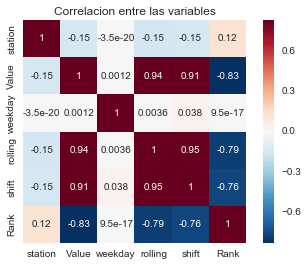

In [19]:
corrmat = train_set.corr()
plt.title('Correlacion entre las variables')
sns.heatmap(corrmat, vmax=.8, square=True, annot=True)

In [20]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor

In [21]:
est = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.01,
         max_depth=2, random_state=0, loss='ls').fit(X_train.values, y_train.values.flatten())

train_set['y_'] = est.predict(X_train.values)

In [22]:
train_set['y_rank'] = train_set.groupby('Date')['y_'].rank(ascending=False, method='first')

In [23]:
Rt = train_set[train_set['station'].isin(head)]['Rank'].values.flatten()
Rt_ = train_set[train_set['station'].isin(head)]['y_rank'].values.flatten()
print 'train Head MSE:',mean_squared_error(Rt, Rt_)

Rt = train_set[train_set['station'].isin(body)]['Rank'].values.flatten()
Rt_ = train_set[train_set['station'].isin(body)]['y_rank'].values.flatten()
print 'train Body MSE:',mean_squared_error(Rt, Rt_)

Rt = train_set[train_set['station'].isin(tail)]['Rank'].values.flatten()
Rt_ = train_set[train_set['station'].isin(tail)]['y_rank'].values.flatten()
print 'train Tail MSE:',mean_squared_error(Rt, Rt_)

train Head MSE: 76.8471879287
train Body MSE: 82.9344993141
train Tail MSE: 90.6414879792


Los errores obtenidos por el MSE muestran una diferencia entre ellos, también se puede observar un error ligeramente menor en aquellas estaciones que pertenecen al head.

Para aumentar la interpretabilidad en los errores, aplicó la raíz cuadrada para cada MSE obtenido, dejando solamente la media del error obtenida para cada distribución.

In [24]:
def ErrorRank(Sample_error):
    sns.set(style="ticks", palette="muted", color_codes=True)

    # Plot the period with horizontal boxes
    ax = sns.boxplot(x="Error", y="Diversity rank", data=Sample_error,
                     whis=np.inf, color="c")

    # Add in points to show each observation
    sns.stripplot(x="Error", y="Diversity rank", data=Sample_error,
                  jitter=True, size=3, color=".3", linewidth=0)

    ax.set_title('Box plot de errores con respecto a distribucion de rango')
    sns.despine(trim=True)

In [25]:
def SampledError(set_):
    Sample_error = pd.DataFrame({'Diversity rank' : [],'Error' : []})

    for i in range(300):
        sample_head = head[np.random.randint(len(head),size=10)]
        sample_body = body[np.random.randint(len(body),size=10)]
        sample_tail = tail[np.random.randint(len(tail),size=10)]

        #head
        Rt = set_[set_['station'].isin(sample_head)]['Rank'].values.flatten()
        Rt_ = set_[set_['station'].isin(sample_head)]['y_rank'].values.flatten()
        Sample_error = Sample_error.append(pd.DataFrame([['Head', mean_squared_error(Rt, Rt_)]], 
                                                        columns=['Diversity rank','Error']),ignore_index=True)
        #body
        Rt = set_[set_['station'].isin(sample_body)]['Rank'].values.flatten()
        Rt_ = set_[set_['station'].isin(sample_body)]['y_rank'].values.flatten()
        Sample_error = Sample_error.append(pd.DataFrame([['Body', mean_squared_error(Rt, Rt_)]], 
                                                        columns=['Diversity rank','Error']),ignore_index=True)
        #tail
        Rt = set_[set_['station'].isin(sample_tail)]['Rank'].values.flatten()
        Rt_ = set_[set_['station'].isin(sample_tail)]['y_rank'].values.flatten()
        Sample_error = Sample_error.append(pd.DataFrame([['Tail', mean_squared_error(Rt, Rt_)]], 
                                                        columns=['Diversity rank','Error']),ignore_index=True)
        
    return Sample_error

In [26]:
Sample_error = SampledError(train_set)
Sample_error.Error = Sample_error.Error.apply(np.sqrt)

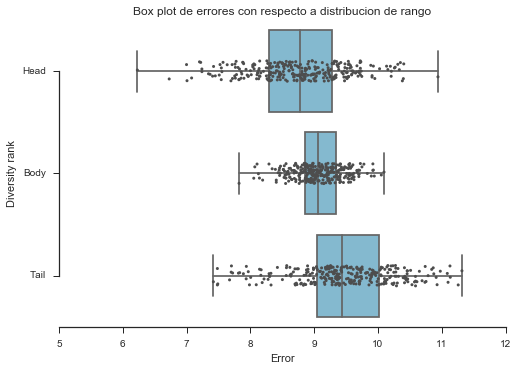

In [27]:
ErrorRank(Sample_error)

Se corre la prueba estadística ANOVA para encontrar si existen medias diferentes entre las variables categóricas de head, body y tail:

In [28]:
import scipy.stats as stats

In [30]:
groups = Sample_error.groupby("Diversity rank").groups

# Etract diversity rank groups
NDCG_head = Sample_error.ix[groups["Head"]].Error.values
NDCG_body = Sample_error.ix[groups["Body"]].Error.values
NDCG_tail = Sample_error.ix[groups["Tail"]].Error.values

In [31]:
# Perform the ANOVA
stats.f_oneway(NDCG_head, NDCG_body, NDCG_tail)

F_onewayResult(statistic=90.123965837974495, pvalue=2.1569158308207288e-36)

Al ver que los resultados de la prueba ANOVA indican medias de error separadas ahora nos dedicamos a realizar la prueba de seguimiento conocida como Tukey test.

group1,group2,meandiff,lower,upper,reject
Body,Head,-0.3153,-0.4413,-0.1892,True
Body,Tail,0.4038,0.2777,0.5298,True
Head,Tail,0.7191,0.593,0.8451,True


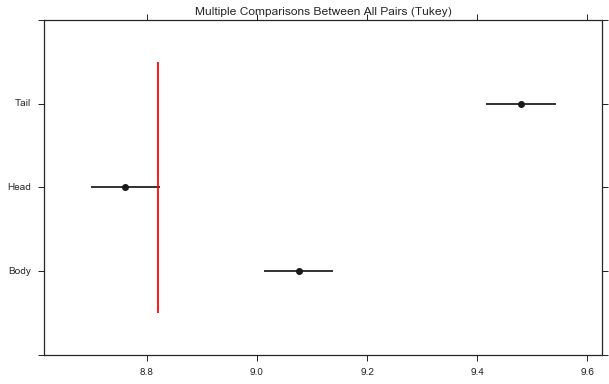

In [38]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(endog=Sample_error.Error.values,     # Data
                          groups=Sample_error['Diversity rank'].values,   # Groups
                          alpha=0.05)          # Significance level

tukey.plot_simultaneous()    # Plot group confidence intervals
plt.vlines(x=8.82,ymin=-0.5,ymax=2.5, color="red")

tukey.summary()              # See test summary

Efectivamente, El error es más bajo la categoría del head. El Tukey test también nos informa que la hipótesis nula: "No existe diferencia entre las medias entre las diferentes categorias" fue rechazada, demostrando que formar parte de las diferentes categorías incide directamente en la diferencia del error medio al momento de realizar el pronóstico para el ranking.

## Test

Para el conjunto de prueba el error en los 3 subconjuntos bajó, también se logra ver que el MSE de la sección correspondiente al head sigue conservando un error menor con respecto a las demás

In [39]:
test_set['y_'] = est.predict(X_test.values)
test_set['y_rank'] = test_set.groupby('Date')['y_'].rank(ascending=False, method='first')

In [40]:
Rt = test_set[test_set['station'].isin(head)]['Rank'].values.flatten()
Rt_ = test_set[test_set['station'].isin(head)]['y_rank'].values.flatten()
print 'Head MSE test:',mean_squared_error(Rt, Rt_)

Rt = test_set[test_set['station'].isin(body)]['Rank'].values.flatten()
Rt_ = test_set[test_set['station'].isin(body)]['y_rank'].values.flatten()
print 'Body MSE test:',mean_squared_error(Rt, Rt_)

Rt = test_set[test_set['station'].isin(tail)]['Rank'].values.flatten()
Rt_ = test_set[test_set['station'].isin(tail)]['y_rank'].values.flatten()
print 'Tail MSE test:',mean_squared_error(Rt, Rt_)

Head MSE test: 47.1174603175
Body MSE test: 63.4457671958
Tail MSE test: 70.492481203


La librería de GBRT cuenta con herramientas de recuperación de información que pueden ayudar a explicar qué tanta información aporta cada variable con la que entrenó el modelo.

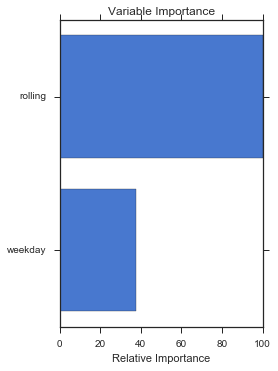

In [41]:
# Plot feature importance
feature_importance = est.feature_importances_

# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

Para este conjunto se parecia que la media móvil explica casi en totalidad el fenómeno sobre el número de conteos que la estación tendrá durante el día.

In [42]:
Sample_error = SampledError(test_set)
Sample_error.Error = Sample_error.Error.apply(np.sqrt)

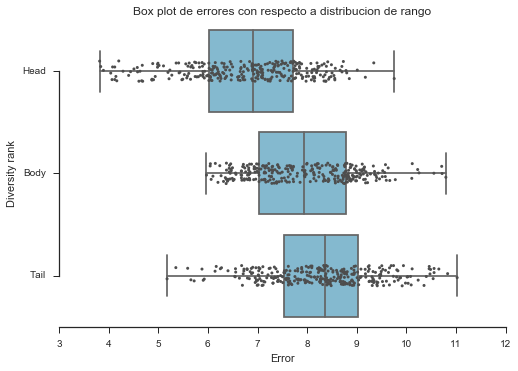

In [43]:
ErrorRank(Sample_error)

In [44]:
# Perform the ANOVA
stats.f_oneway(NDCG_head, NDCG_body, NDCG_tail)

F_onewayResult(statistic=90.123965837974495, pvalue=2.1569158308207288e-36)

group1,group2,meandiff,lower,upper,reject
Body,Head,-1.1444,-1.36,-0.9288,True
Body,Tail,0.3731,0.1575,0.5887,True
Head,Tail,1.5175,1.3018,1.7331,True


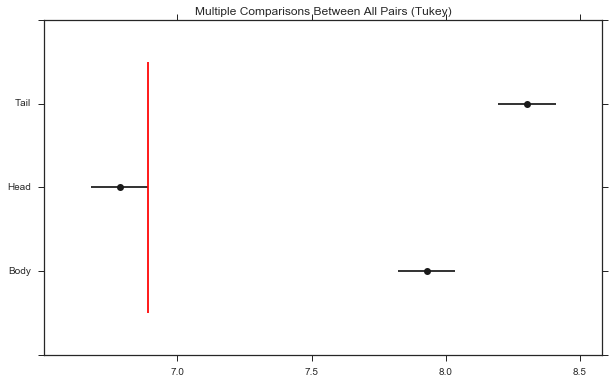

In [47]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(endog=Sample_error.Error.values,     # Data
                          groups=Sample_error['Diversity rank'].values,   # Groups
                          alpha=0.05)          # Significance level

tukey.plot_simultaneous()    # Plot group confidence intervals
plt.vlines(x=6.89,ymin=-0.5,ymax=2.5, color="red")

tukey.summary()              # See test summary

Conclusiones:

- El experimento que se realizó aquí indica que efectivamente existe una diferencia en la calidad de predicción que las estaciones obtienen con el modelo seleccionado, aportando evidencia de que la hipótesis planteada.
- Cabe notar que en este ejercicio solo hicimos uso de dos variables relevantes: La media móvil y el día de la semana. El desempeño del modelo podría mejorar haciendo uso de más variables que expliquen la dinámica empleada en las ciudades: temperatura, precipitación son algunos modelos que se ha observado una dramática mejora al momento de ser integrados en modelos para BSSs.

In [1]:
from IPython.display import HTML
#To hide code from the nbviewer render
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')